$\Huge{\text{Modelisation du cours du BITCOIN}}$

<hr><b>
<hr><b>

$\huge{\text{Groupe KAGLAN KHABIE KHENESSI}}$

# Les Imports

Remarque : Le module arch est appellé dans les imports. Il faudra l'installer avec la commande !pip install arch 

In [367]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from arch.unitroot import ADF
import pmdarima as pmd
plt.rcParams['figure.figsize']=(10,8)
plt.rc('axes', labelsize = 15)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.style.use('seaborn-whitegrid')

# Récupération de la donnée

Cours de Cloture du BITCOIN sur 10 ans (du 06-12-2011 au 23-12-2021 )

In [368]:
!wget https://minio.lab.sspcloud.fr/mawulikaglan/BTCUSD_10AN.txt
!ls

--2022-01-06 14:10:00--  https://minio.lab.sspcloud.fr/mawulikaglan/BTCUSD_10AN.txt
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.151, 192.168.253.152
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180782 (177K) [binary/octet-stream]
Saving to: ‘BTCUSD_10AN.txt.2’

BTCUSD_10AN.txt.2   100%[===================>] 176.54K  --.-KB/s    in 0.006s  

2022-01-06 14:10:00 (30.9 MB/s) - ‘BTCUSD_10AN.txt.2’ saved [180782/180782]

 BTCUSD_10AN.txt    'Charles-Travail de modelisation .ipynb'
 BTCUSD_10AN.txt.1  'Notebook DataScience Project - Webscrapping.ipynb'
 BTCUSD_10AN.txt.2  'Notebook Webscrapping using Selenium - Final.ipynb'
 BTCUSD.txt	     Untitled.ipynb


## Importation des données :

In [605]:
BTC = pd.read_csv('BTCUSD_10AN.txt', sep="\t", parse_dates=[0], index_col=0)

In [370]:
for x in BTC:
    print(x)

ouv
haut
bas
clot
vol
devise
Unnamed: 7


In [455]:
BTC_1=BTC['2017-01-01':].copy()

In [515]:
Close = BTC_1['clot']

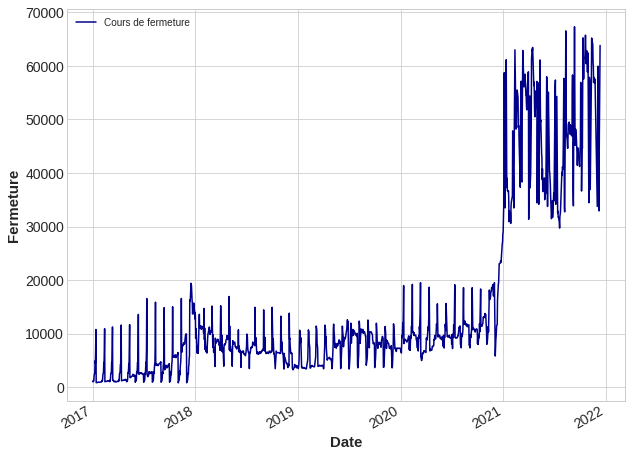

In [544]:
Close.plot(color='darkblue', label='Cours de fermeture')
plt.ylabel('Fermeture', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

## Serie des log-returns

In [545]:
logrets=Close.pct_change().apply(lambda x: np.log(1 + x)).dropna()

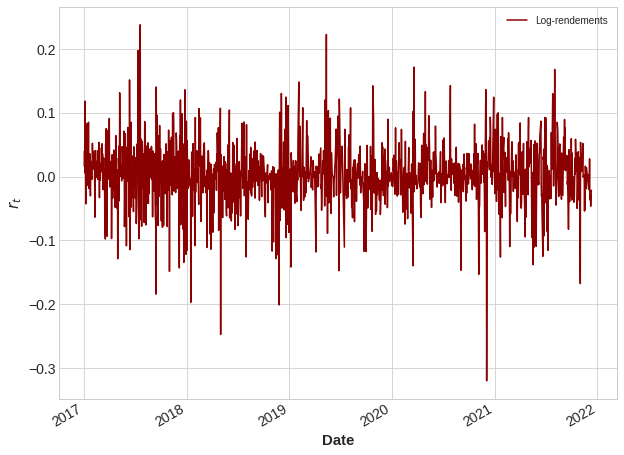

In [546]:
logrets.plot(color='darkred', label='Log-rendements')
plt.ylabel(r'$r_t$', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

## Analyse des données

 ### Statistiques descriptives

#### Observation de la queue et de la tête des données de log-rendements

In [547]:
logrets.tail(), logrets.head()

(date
 2021-11-17   -0.012077
 2021-11-18   -0.051807
 2021-11-19    0.016305
 2021-11-22   -0.019078
 2021-11-23    0.014019
 Name: clot, dtype: float64,
 date
 2017-02-01    0.031602
 2017-03-01    0.017596
 2017-04-01    0.091093
 2017-05-01   -0.128773
 2017-06-01   -0.108510
 Name: clot, dtype: float64)

#### Statistiques descriptives

In [548]:
logrets.describe()

count    1395.000000
mean        0.002914
std         0.047480
min        -0.320083
25%        -0.017267
50%         0.003186
75%         0.026100
max         0.237815
Name: clot, dtype: float64

In [549]:
Sk = stats.skew
K = stats.kurtosis

In [550]:
Sk(logrets), K(logrets), K(logrets)-3

(-0.3668033851127422, 4.246664192750607, 1.2466641927506066)

Commentaire :

### Préliminaires à la modelisation

#### Etude de la Normalité des log-returns

In [551]:
stats.shapiro(logrets)

ShapiroResult(statistic=0.9449649453163147, pvalue=2.1761882962886854e-22)

In [552]:
stats.kstest(logrets, 'norm')

KstestResult(statistic=0.4398717626222267, pvalue=2.9840982370875244e-246)

$\textbf{Interprétation:} $ 

Avec les tests de Shapiro et de Kolmogorov Smirnov on a une p-value<5%. On a alors H0 ne rejette donne pas H0 selon laquelle notre distribution est normale. D'où  

#### Fonction de densité empirique de la série des log-returns (KDE)

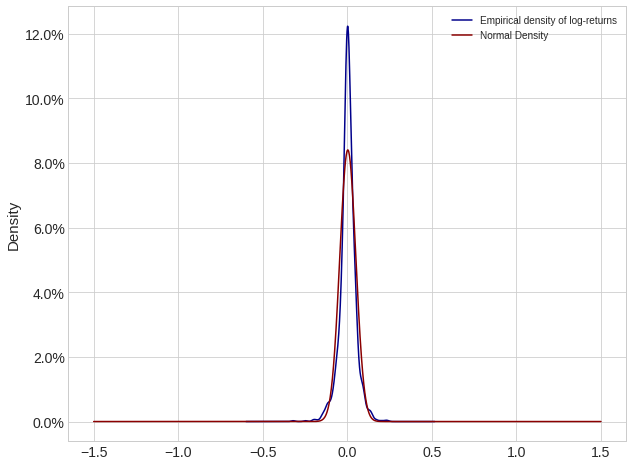

In [553]:
logrets.plot(kind='kde', color='darkblue', label='Empirical density of log-returns')
plt.yticks(plt.yticks()[0],[str(x)+'%' for x in plt.yticks()[0]])
x=np.linspace(-1.5, 1.5, len(logrets))
plt.plot(x, stats.norm.pdf(x, logrets.mean(), logrets.std()), color='darkred', label='Normal Density')
plt.legend()

#### Fonction de répartition empirique de la série de log returns

In [554]:
p = stats.norm.fit(logrets)

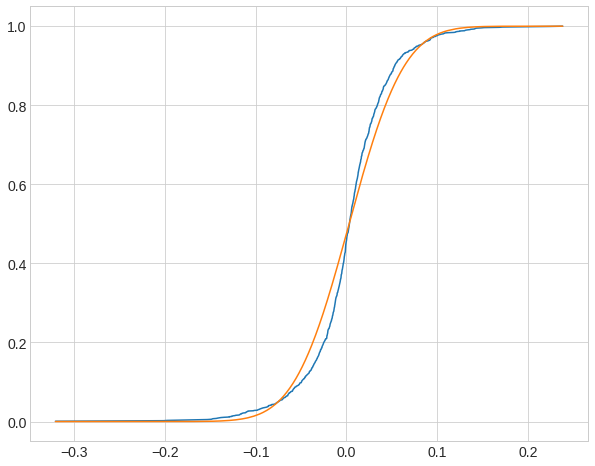

In [555]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(logrets)
x = ecdf.x
plt.plot(x, ecdf.y)
plt.plot(x, stats.norm.cdf(x, *p))

#### Diagrams QQ-plot of log-returns

(-4.0, 4.0)

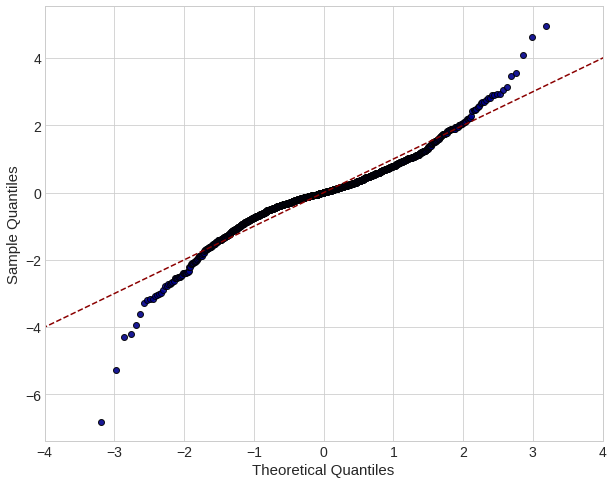

In [556]:
import statsmodels.api as sm
pp = sm.ProbPlot(logrets, fit=True)
qq = pp.qqplot(marker='o', markerfacecolor='darkblue', markeredgecolor='k', alpha=0.9)
sm.qqline(qq.axes[0], line='45', color='darkred', linestyle='dashed')
plt.xlim((-4,4))

#### Analyse de la stationarité : Test des Dickey-Fuller Augmenté (ADF-Augmented Dickey-Fuller Test)

##### Remarque : Il faut ici avoir d'abord installé le module arch avec la commande !pip install arch 

In [557]:
from arch.unitroot import ADF
trends = ['ct', 'c', 'n' ]
for t in trends:
    r=ADF(logrets, trend=t)
    print(r,'\n')

   Augmented Dickey-Fuller Results   
Test Statistic                -25.136
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                -25.145
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                -25.016
P-value                         0.000
Lags                                1
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), 

Commentaire: 

#### Fonction d'autocorrélation partiel et Fonction d'autocorrélation (ACF /PACF )

In [473]:
def AcfPacf(data, model=''):
    fig, ax = plt.subplots(2)
    smt.graphics.plot_acf(data, ax=ax[0], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    smt.graphics.plot_pacf(data, ax=ax[1], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    for item, itemm in zip(ax[0].collections, ax[1].collections):
        if ((type(item)==PolyCollection) & (type(itemm)==PolyCollection)) :
            item.set_facecolor('darkred')
            itemm.set_facecolor('darkred')
    ax[0].set_title('ACF' +model,fontdict={'weight':'bold'})
    ax[1].set_title('PACF' +model,fontdict={'weight':'bold'})
    return None

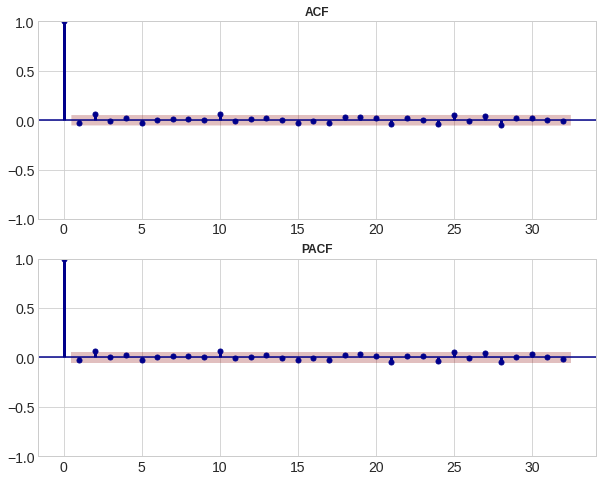

In [558]:
AcfPacf(logrets)

##### Commentaire : 
On remarque dans l’ACF que presque la majorité des autocorrélations, à l’exception de uelues unes comme la première, la troisième et la cinuième sont nulles au risque d’erreur de 5%. Le même constat s’applique
au PACF. 
Ce résultat est très connu dans les marchés financiers liquides et est souvent cité comme un
argument ”empirique” de l’hypothèse d’efficience des marchés financiers. 

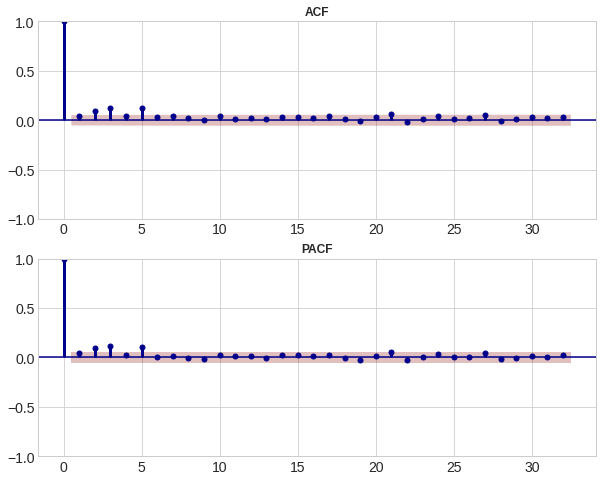

In [559]:
AcfPacf((logrets)**2)

##### Interprétation : 
Considérant maintenant, l’ACF et le PACF de la série des carrés des log-rendements, on remarque que les carrés des
log-rendements exhibent des autocorrélations significativement non nulles, jusqu’à l’ordre 7 ! Et les autaucorrélations patielles significativement non nulles, jusqu’à l’ordre 5.

#### Lag-plots et intérêts à la prédiction

389  : ( -0.0247 , -0.2474  )
------------------------------
390  : ( -0.2474 , 0.1043  )
------------------------------


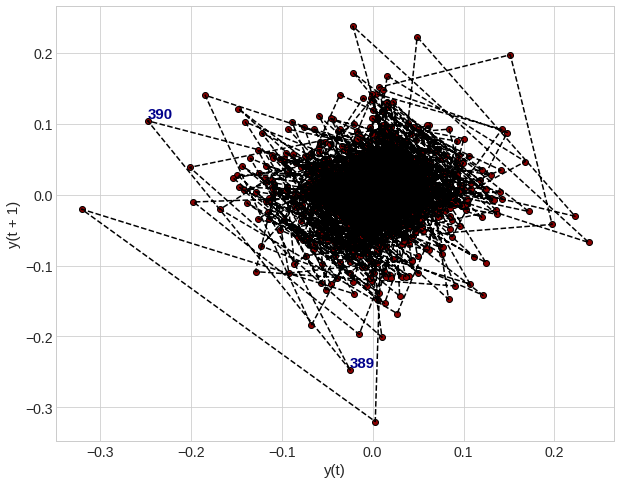

In [567]:
plt.rcParams['patch.facecolor']='darkred'
plt.plot(logrets.shift(1), logrets,'k--')
pd.plotting.lag_plot(logrets, 1, edgecolor='black')
for i in range(389,391):
    plt.annotate(str(i), (logrets.shift(1)[i], logrets[i]+0.004),fontweight='bold',fontsize=15, color='darkblue')
    print(str(i),' : ( %.4f' %logrets.shift(1)[i],', %.4f ' %logrets[i],')\n------------------------------')

# Modelisation et Prevision (Forecasting)

## Modèle linéaire ARIMA : 

### Estimation des parametres du Modèle ARIMA

In [568]:
for p in range(1,3):
    for q in range(1,3):
        mdl=smt.ARIMA(logrets, order=(p,0,q), trend='c').fit()
        res=mdl.resid
        lj=sm.stats.diagnostic.acorr_ljungbox(res, lags=[5], model_df=p+q,return_df=True)
        pv=lj.values[0][1]
        print('model : ARIMA (',p,',0,',q,')', 'AIC : ',np.round(mdl.aic,4),'p-value : ',np.round(pv, 4))

model : ARIMA ( 1 ,0, 1 ) AIC :  -4542.9603 p-value :  0.4702
model : ARIMA ( 1 ,0, 2 ) AIC :  -4540.9718 p-value :  0.3505
model : ARIMA ( 2 ,0, 1 ) AIC :  -4541.2559 p-value :  0.4035
model : ARIMA ( 2 ,0, 2 ) AIC :  -4540.1041 p-value :  0.3016


### Estimation des résidus du model

In [569]:
import pmdarima as pmd

In [570]:
mean_mdl=pmd.auto_arima(logrets, start_q=0, start_p=0)

In [571]:
residuals = pd.Series(mean_mdl.resid(), index=logrets.index)

In [573]:
stats.kstest(residuals, 'norm')

KstestResult(statistic=0.4402907241730616, pvalue=9.598111041042723e-247)

In [574]:
logrets.index

DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01',
               ...
               '2021-10-11', '2021-11-11', '2021-12-11', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23'],
              dtype='datetime64[ns]', name='date', length=1395, freq=None)

#### Interprétation: 
On a une p-value>5% alors on ne rejette pas l'hypothèse Ho selon laquelle les résidus suivent une loi normale. 

### Estimation de la Volatilité sous le Modèle ARIMA(1,0,1)

In [621]:
class VolatilityEst:
    __Estimators__ = ['Rolling', 'EWMA', 'RogersSatchell', 'Parkinson', 'GarmanKlass']

    def __init__(self, data):
        self.data = data
        return None
    def printNames(self):
        return VolatilityEst.__Estimators__    

    def __getLret(self, close):
        return close.pct_change().apply(lambda x: np.log(1 + x)).dropna()

    def Estimate(self, window = 5, name = 'Rolling'):
        if (name == 'Rolling'):
            est = np.sqrt((self.__getLret(self.data['clot'])**2).rolling(window).mean())

        if(name == 'EWMA'):
            est = np.sqrt((self.__getLret(self.data['clot'])**2).ewm(alpha=1.-0.94).mean())
             

        if(name == 'RogersSatchell'):
            est = np.sqrt( (np.log(self.data['haut']/self.data['bas']) * np.log(self.data['haut']/self.data['clot']) + np.log(self.data['bas']/self.data['ouv']) * np.log(self.data['bas']/self.data['clot'])).rolling(window).mean())

        if(name == 'Parkinson'):
            est = np.sqrt(((0.25/np.log(2))*(np.log(self.data['haut']/self.data['bas']))**2).rolling(window).mean())

        if(name == 'GarmanKlass'):
            c = window/(window-1)
            est = np.sqrt((0.51*c*(np.log(self.data['haut']/self.data['bas']))**2 - 0.39*c*self.__getLret(self.data['clot'])**2).rolling(window).mean())

        return est[:'2021-12-31']

In [622]:
BTC_2=BTC['2020-01-01':].copy()
Close_2=Close['2020-01-01':]
logreturns=Close_2.pct_change().apply(lambda x: np.log(1 + x)).dropna()
vol = VolatilityEst(BTC_2)

In [624]:
vol.printNames()

['Rolling', 'EWMA', 'RogersSatchell', 'Parkinson', 'GarmanKlass']

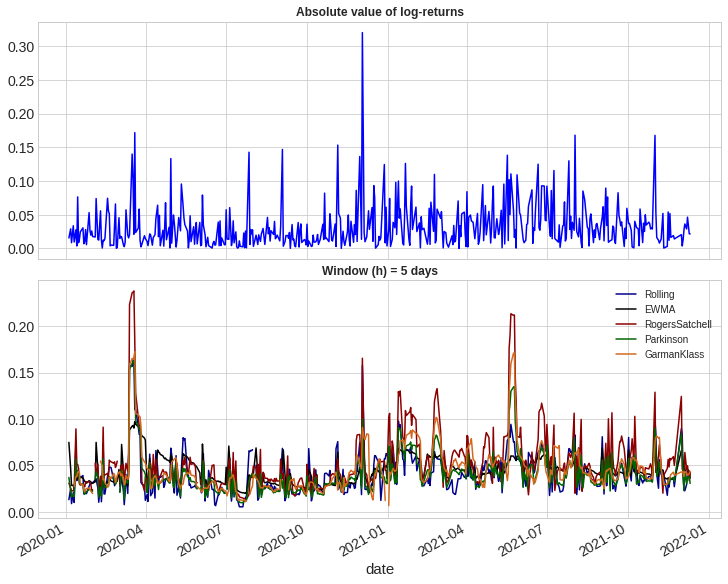

In [623]:
colors = ['darkblue', 'black', 'darkred', 'darkgreen', 'chocolate']
fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True)
logreturns.apply(lambda x: np.abs(x)).plot(color='blue', ax=axs[0])
axs[0].set_title('Absolute value of log-returns', fontdict={'weight':'bold'})
for name, color in zip(vol.printNames(), colors):
    vol.Estimate(name=name).plot(label=name, color=color, ax=axs[1])
plt.title('Window (h) = 5 days', fontdict={'weight':'bold'})
plt.legend()

## Modèle GARCH

### Test de la Validité du Modèle: 

In [525]:
from statsmodels.stats.diagnostic import het_arch

In [526]:
test_arch=het_arch(residuals, nlags=1)
name=["LM","LM p-value", "F", "F p-value"]
res_arch=pd.Series(test_arch, index=name)
res_arch

LM            2.370084
LM p-value    0.123680
F             2.370714
F p-value     0.123858
dtype: float64

### Formulation du Modèle GARCH(p,0,q)

In [ ]:
!pip install pandas_datareader

     |████████████████████████████████| 109 kB 335 kB/s            
     |████████████████████████████████| 6.9 MB 80 kB/s             


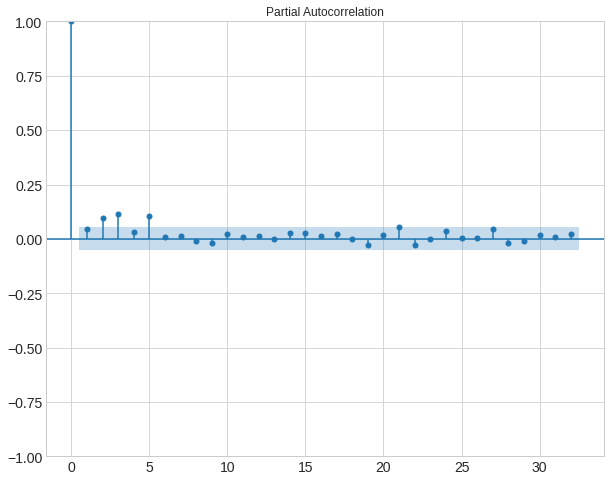

In [625]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

plot_pacf(logrets**2)
plt.show()

In [626]:
model = arch_model(logrets, p=1, q=1)

In [627]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -2333.528285622524
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2333.5282856036356
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


In [628]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   clot   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2333.53
Distribution:                  Normal   AIC:                          -4659.06
Method:            Maximum Likelihood   BIC:                          -4638.09
                                        No. Observations:                 1395
Date:                Thu, Jan 06 2022   Df Residuals:                     1394
Time:                        15:41:25   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.9142e-03  1.112e-03      2.621  8.757e-03 [7.353e-04,5.093e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.2527e-04  1.345e-04      1.676  9.383e-02 [-3.824e-05,4.888e-04]
alpha[1]       0.1000  2.633e-02      3.798  1.457e-04    [4.840e-02,  0.152]
beta[1]        0.8000  7.070e-02     11.315  1.110e-29      [  0.661,  0.939]
=============================================================================

Covariance estimator: robust
"""

### Forcasting avec GARCH(1,0,1)

In [575]:
rolling_predictions = []
test_size = 100

for i in range(test_size):
    train = logrets[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [577]:
rolling_predictions = pd.Series(rolling_predictions, index=logrets.index[-100:])

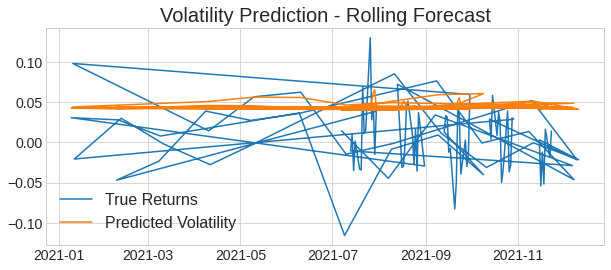

In [578]:
plt.figure(figsize=(10,4))
true, = plt.plot(logrets[-100:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

## La prévision par lissage exponentiel (Exponential smoothing )

In [347]:
ES = smt.ExponentialSmoothing
SES = smt.SimpleExpSmoothing


**(1-$\alpha$) Conf-int** : 

$[$ $z_{\alpha}$ : $\alpha$ quantile of the standard normal dist, $\beta$ : smoothing parameter ($\beta = 1-\gamma$ where $\gamma$ is the smoothing param in Python)$]$

- **SES** :  $ [ \ \hat{r}_t(h) - z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta),\  \hat{r}_t(h) + z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta) \  ]$ where : $$C^2(h, \beta)= 1 + \frac{1-\beta}{(1+\beta)^3} \left[(1+4\beta + 5\beta^2) + 2h(1-\beta)(1+3\beta) + 2h^2(1-\beta)^2 \right] $$

In [612]:
import warnings
warnings.filterwarnings('ignore')

class ExpSmooth:
    def __init__(self, data):
        self.data = data
        return None

    def __C(self, h, beta):
        return 1 + ((1-beta)/(1+beta**3))*(1+4*beta+5*beta**2 + 2*h*(1-beta)*(1+3*beta) + 2*(h**2)*(1-beta)**2)

    def __ConfInt(self, forecasts, beta,  method, horizon, alpha=.05):
        idx = forecasts.index[0]
        ci = []
        sigma = self.data.std()
        z = stats.norm.ppf(1-alpha/2)
        for h in range(horizon):
            ci.append([forecasts[idx + h]-z*sigma*np.sqrt(self.__C(h, beta)),forecasts[idx + h]+z*sigma*np.sqrt(self.__C(h, beta))])
        return pd.DataFrame(ci, columns=['down', 'up'])

    def SES(self, forecasts_horizon=1):
        ses_fit = SES(self.data, initialization_method='estimated').fit()
        ses_forecasts = ses_fit.forecast(forecasts_horizon).rename(r'$\beta = %s$'%np.round(1 - ses_fit.params['smoothing_level'], 3))
        beta = 1-ses_fit.params['smoothing_level']
        return ses_fit, ses_forecasts, self.__ConfInt(ses_forecasts, beta= beta, method='SES', horizon=forecasts_horizon)

In [613]:
es = ExpSmooth(logrets)

In [614]:
lrets_predict=logrets['2021-06-01':].copy()
ses_fit, ses_forecasts, ses_ci = es.SES(forecasts_horizon=len(lrets_predict))

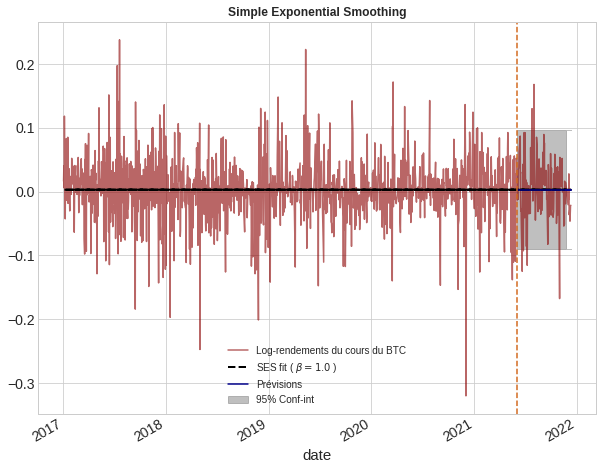

In [615]:
logrets.plot(color='darkred', alpha=0.6)
plt.plot(ses_fit.fittedvalues, color='black', linestyle='dashed', linewidth=2)
plt.plot(lrets_predict.index, ses_forecasts, color='darkblue')
plt.fill_between(lrets_predict.index, ses_ci['down'],ses_ci['up'], color='gray', alpha=0.5)
plt.title('Simple Exponential Smoothing', fontdict={'weight':'bold'})
plt.legend(['Log-rendements du cours du BTC','SES fit ( '+ ses_forecasts.name +' )', 'Prévisions','95% Conf-int'])
plt.axvline(x=lrets_predict.index[0], linestyle='dashed', color='chocolate')

 ### Erreur de prédiction

In [616]:
def RMSE(data1, data2):
    n = len(data1)
    print('RMSE : ')
    return np.sqrt(((data2-data1)**2).sum()/n)

In [618]:
RMSE(ses_forecasts, lrets_predict.values)

RMSE : 


0.047411915397901475